In [1]:
import sys
import glob
from pathlib import Path
sys.path.append('./extract_patches.py')
import extract_patches as ep
from matplotlib import pyplot as plt
import numpy as np

In [74]:
def show_info(x,show_values = False):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    if hasattr(x,'__len__'):
        length = len(x)
    if isinstance(x,dict):
        keys = x.keys()
        values = x.values()
    if type(x) is np.ndarray:
        shape = x.shape
        size = x.size
    print(f'type:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\noriginal info:{x}')
    if show_values:
        print(f'\nvalues:{values}')

def null_or_not(x,pr = False):  #只要有一个元素不为0则不为0
    if type(x) is not np.ndarray:
        x = np.array(x)
    if pr:
        if x.any():
            print('not all 0')
        else:
            print('all 0')
    return x.any()

def show_dzg_info(dzg):
    print(f'level count:{dzg.level_count}')
    print(f'tile arrangement of last 3 level{dzg.level_tiles[-4:-1]}\ndimensions of each tile at last 3 level:{dzg.level_dimensions[-4:-1]}')

def pop_tile(dzg,level):
    row,col = dzg.level_tiles[level]
    if level<0:
        level = dzg.level_count + level
    for i in range(row):
        for j in range(col):
            if null_or_not(dzg.get_tile(level,(i,j))):
                print((i,j))

In [3]:
root_path = {
    'server':'/mnt/wangyh/TCGA_bladder/TCGA_bladder/',
    'desktop':'I:\\TCGA_bladder\\TCGA_bladder\\',
    'laptop':''
}
file_id = '1a985a2b-c025-4336-a0f5-8b13fbbbba91' + '/'

In [4]:
file_path = root_path['server'] + file_id
svs_path = glob.glob(file_path + '*.svs')[0]
xml_path = glob.glob(file_path + '*.xml')[0]

/home/wangyh/uro_biomarker/patho_AI/processing/extract_patches.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(mask_coords[cls])


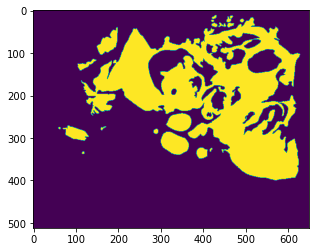

In [5]:
slide = ep.get_slide(svs_path) #svs_path是一个list
mask_coords,classes = ep.AnnotationParser(xml_path)
rule =  {"tumor":{"excludes":["artificial","stroma","necrosis"]},
        'stroma':{"excludes":['artificial','necrosis']}}

annos = ep.Annotation(slide,xml_path,rule=rule)
masked_tumor = ep.show_thumb_mask(annos['tumor'])
tumor_slide = ep.get_mask_slide(annos)


In [9]:
tumor_thumbnail = tumor_slide.get_thumbnail((1000,500))

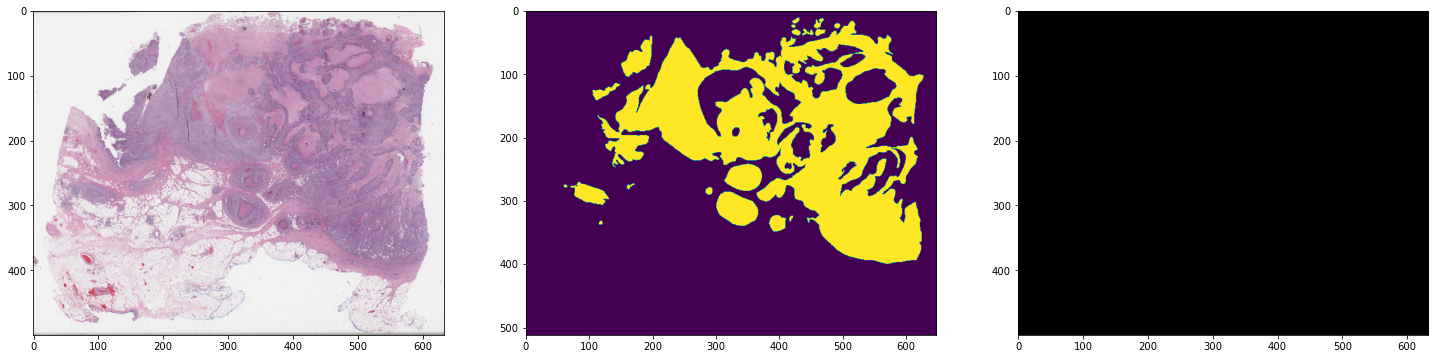

In [10]:
figure = plt.figure(figsize=(25,10))
original = plt.subplot(131)
original.imshow(slide.get_thumbnail((1000,500)))
mask = plt.subplot(132)
mask.imshow(masked_tumor)
tumorslide = plt.subplot(133)
tumorslide.imshow(tumor_thumbnail)

In [13]:
TILE_SIZE = 512
slide_tiles,tumor_tiles = ep.get_tiles(slide,tumor_slide,tile_size = TILE_SIZE)

type:<class 'openslide.deepzoom.DeepZoomGenerator'> 
len:no length
shape:not a ndarray
size:not a ndarray
keys:not a dict
original info:DeepZoomGenerator(OpenSlide('/mnt/wangyh/TCGA_bladder/TCGA_bladder/1a985a2b-c025-4336-a0f5-8b13fbbbba91/TCGA-DK-A3IM-01Z-00-DX1.ED1A8B22-566E-4A95-AF6D-7C9E536BE2B7.svs'), tile_size=512, overlap=False, limit_bounds=False)


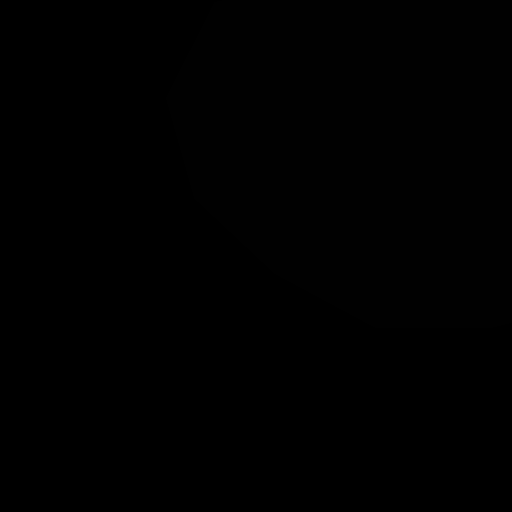

In [72]:
tumor_tiles.get_tile(16,(12,49))

In [75]:
pop_tile(tumor_tiles,-2)

(10, 48)
(10, 49)
(11, 48)
(11, 49)
(12, 48)
(12, 49)
(13, 48)
(13, 49)
(13, 50)
(13, 51)
(13, 52)
(14, 47)
(14, 48)
(14, 49)
(14, 50)
(14, 51)
(14, 52)
(15, 48)
(15, 49)
(15, 50)
(15, 51)
(15, 52)
(15, 53)
(16, 48)
(16, 49)
(16, 50)
(16, 51)
(16, 52)
(16, 53)
(17, 48)
(17, 49)
(17, 50)
(17, 51)
(17, 52)
(17, 53)
(18, 22)
(18, 23)
(18, 24)
(18, 49)
(18, 50)
(18, 51)
(18, 52)
(18, 53)
(19, 22)
(19, 23)
(19, 24)
(19, 25)
(19, 29)
(19, 49)
(19, 50)
(19, 51)
(19, 52)
(19, 53)
(19, 54)
(20, 22)
(20, 23)
(20, 24)
(20, 25)
(20, 29)
(20, 30)
(20, 49)
(20, 50)
(20, 51)
(20, 52)
(20, 53)
(20, 54)
(20, 58)
(20, 59)
(21, 22)
(21, 23)
(21, 24)
(21, 30)
(21, 31)
(21, 32)
(21, 33)
(21, 34)
(21, 50)
(21, 51)
(21, 52)
(21, 53)
(21, 54)
(21, 58)
(21, 59)
(22, 21)
(22, 22)
(22, 23)
(22, 24)
(22, 30)
(22, 31)
(22, 32)
(22, 33)
(22, 34)
(22, 35)
(22, 36)
(22, 37)
(22, 38)
(22, 50)
(22, 51)
(22, 52)
(22, 53)
(23, 21)
(23, 22)
(23, 23)
(23, 31)
(23, 32)
(23, 33)
(23, 34)
(23, 35)
(23, 36)
(23, 37)
(23, 38)
(